# 1) Ridge regression, lasso, and elastic net: cross-validation & comparison

We will try to predict player salary from the rest of the variables in the dataset.

First, read in the data, extract response and predictors, split the data into training and testing subsets, apply one-hot encoding (a binary column for each possible value) to categorical variables, and define a range of alpha values.

In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# set random seed
seed = 42
np.random.seed(seed)

# in case we want to disable truncation when viewing dataframes
# pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.set_option("display.max_rows", 40, "display.max_columns", None)

# suppress scikit-learn's warnings (https://stackoverflow.com/a/33616192)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# read in the data
hitters = pd.read_csv('../../data/Hitters.csv').dropna().drop('Player', axis=1)

# we'll try to predict salary from the dataset's other variables
y = hitters.Salary

# remove the response and the player names from the subset of predictors
X = hitters.drop(['Salary', 'AtBat'], axis = 1)

X.reset_index(drop=True, inplace=True)

cat = X[['League', 'Division', 'NewLeague']]

# first a label encoding to convert ints to strings then one-hot
lae = LabelEncoder()
ohe = OneHotEncoder()
# cat.apply(LabelEncoder().fit_transform)
ohe.fit(cat)
print(f"OHE categories: {[list(c) for c in ohe.categories_]}")

# attach the OHE columns to the predictors dataframe
cat_oh = pd.DataFrame(ohe.transform(cat).toarray(), columns=['League_A', 'League_N', 'Division_E', 'Division_W', 'NewLeague_A', 'NewLeague_N'])
X_oh = pd.concat([X.drop(['League', 'Division', 'NewLeague'], axis=1), cat_oh], axis=1)
print(f"OHE dataframe:\n{X_oh}")

# separate training and testing data
X_train, X_test, y_train, y_test = train_test_split(X_oh, y, test_size=0.5)

# create a range of alpha values
alphas = 10**np.linspace(10, -10, 100) * 0.5

OHE categories: [['A', 'N'], ['E', 'W'], ['A', 'N']]
OHE dataframe:
     Hits  HmRun  Runs  RBI  Walks  Years  CAtBat  CHits  CHmRun  CRuns  CRBI  \
0      81      7    24   38     39     14    3449    835      69    321   414   
1     130     18    66   72     76      3    1624    457      63    224   266   
2     141     20    65   78     37     11    5628   1575     225    828   838   
3      87     10    39   42     30      2     396    101      12     48    46   
4     169      4    74   51     35     11    4408   1133      19    501   336   
..    ...    ...   ...  ...    ...    ...     ...    ...     ...    ...   ...   
258   127      7    65   48     37      5    2703    806      32    379   311   
259   136      5    76   50     94     12    5511   1511      39    897   451   
260   126      3    61   43     52      6    1700    433       7    217    93   
261   144      9    85   60     78      8    3198    857      97    470   420   
262   170      9    77   44     31     11

Fit a ridge regression model across the range of alphas and plot regularization paths.

In [180]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

ridge = Ridge(normalize=True, random_state=seed)
ridge_coefs = []
ridge_errors = []

# iterate over alphas and fit a ridge model for each
# approach adapted from https://www.science.smith.edu/~jcrouser/SDS293/labs/lab10-py.html
for a in alphas:
    # configure alpha and fit the model
    ridge.set_params(alpha=a)
    ridge.fit(X_train, y_train)

    # get coefficients, make predictions on test set, and calculate MSE
    coefs = ridge.coef_
    error = mean_squared_error(y_test, ridge.predict(X_test))

    # save coefficients and MSE
    ridge_coefs.append(coefs)
    ridge_errors.append(error)

As expected, coefficient estimates shrink as lambda grows, reflecting an increased penalty for $ \beta $.

Next, fit a ridge regression model with cross-validation, and indicate the selected model in the plots.

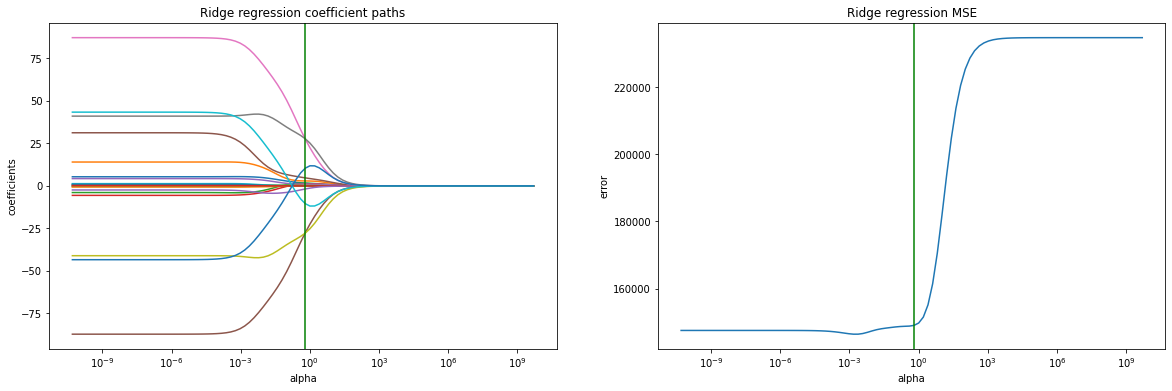

In [181]:
from sklearn.linear_model import RidgeCV

# perform cross-validation across the range of alphas
ridge_cv = RidgeCV(alphas, normalize=True)
ridge_cv.fit(X_train, y_train)

# best-fitting ridge model
bf_ridge = Ridge(alpha=ridge_cv.alpha_, normalize=True, random_state=seed)
bf_ridge.fit(X_oh, y)
bf_ridge_coefs = pd.Series(bf_ridge.coef_, index = X_oh.columns)
bf_ridge_error = mean_squared_error(y_test, bf_ridge.predict(X_test))

# make plots
# plotting code adapted from https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_coeffs.html#sphx-glr-auto-examples-linear-model-plot-ridge-coeffs-py
plt.figure(figsize=(20, 6))

# plot coefficient paths and selecte
plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, ridge_coefs)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("coefficients")
plt.title("Ridge regression coefficient paths")
plt.axvline(x=ridge_cv.alpha_, color='green')
plt.axis("tight")

# plot MSE
plt.subplot(122)
ax = plt.gca()
ax.plot(alphas, ridge_errors)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("error")
plt.title("Ridge regression MSE")
plt.axvline(x=ridge_cv.alpha_, color='green')
plt.axis("tight")
plt.show()

Now with a LASSO model.

In [182]:
from sklearn.linear_model import Lasso

lasso = Lasso(max_iter=10000, normalize=True, random_state=seed)
lasso_coefs = []
lasso_errors = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)

    coefs = lasso.coef_
    error = mean_squared_error(y_test, lasso.predict(X_test))

    lasso_coefs.append(coefs)
    lasso_errors.append(error)

Now perform cross-validation to select the best-fitting LASSO model and plot regularization paths and MSE as functions of $ \alpha $ again.

<Figure size 1440x432 with 0 Axes>

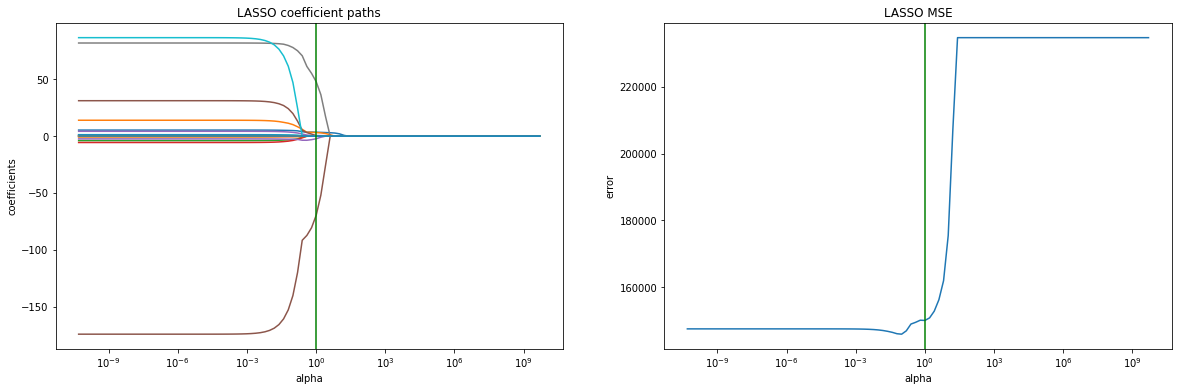

In [183]:
from sklearn.linear_model import LassoCV

# perform cross-validation across the range of alphas
lasso_cv = LassoCV(alphas=alphas, cv=10, max_iter=100000, normalize=True, random_state=seed)
lasso_cv.fit(X_train, y_train)

# best-fitting LASSO model
bf_lasso = Lasso(alpha=lasso_cv.alpha_, normalize=True, random_state=seed)
bf_lasso.fit(X_oh, y)
bf_lasso_coefs = pd.Series(bf_lasso.coef_, index = X_oh.columns)
bf_lasso_error = mean_squared_error(y_test, bf_lasso.predict(X_test))

# make plots
plt.figure(figsize=(20, 6))

# coefficient paths
plt.figure(figsize=(20, 6))
plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, lasso_coefs)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("coefficients")
plt.title("LASSO coefficient paths")
plt.axvline(x=lasso_cv.alpha_, color='green')
plt.axis("tight")

# MSE
plt.subplot(122)
ax = plt.gca()
ax.plot(alphas, lasso_errors)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("error")
plt.title("LASSO MSE")
plt.axvline(x=lasso_cv.alpha_, color='green')
plt.axis("tight")
plt.show()

Now repeat the same process with elastic net.

In [184]:
from sklearn.linear_model import ElasticNet

net = ElasticNet(normalize=True, random_state=seed)
net_coefs = []
net_errors = []

for a in alphas:
    net.set_params(alpha=a)
    net.fit(X_train, y_train)

    coefs = net.coef_
    error = mean_squared_error(y_test, net.predict(X_test))

    net_coefs.append(coefs)
    net_errors.append(error)

Perform cross-validation with the elastic net.

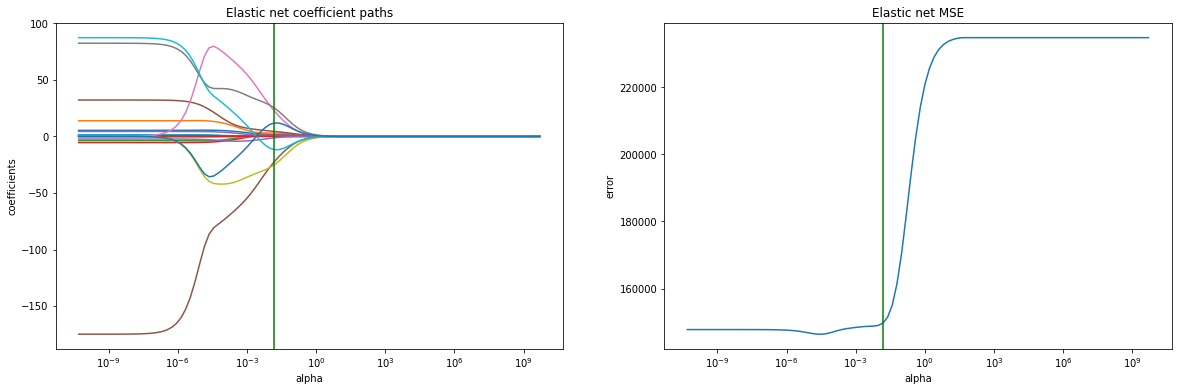

In [185]:
from sklearn.linear_model import ElasticNetCV

# perform cross-validation across the range of alphas
net_cv = ElasticNetCV(alphas=alphas, cv=10, max_iter=100000, normalize=True, random_state=seed)
net_cv.fit(X_train, y_train)

# best-fitting elastic net
bf_net = ElasticNet(alpha=net_cv.alpha_, normalize=True, random_state=seed)
bf_net.fit(X_oh, y)
bf_net_coefs = pd.Series(bf_net.coef_, index = X_oh.columns)
bf_net_error = mean_squared_error(y_test, bf_net.predict(X_test))

# coefficient paths
plt.figure(figsize=(20, 6))
plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, net_coefs)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("coefficients")
plt.title("Elastic net coefficient paths")
plt.axvline(x=net_cv.alpha_, color='green')
plt.axis("tight")

# MSE
plt.subplot(122)
ax = plt.gca()
ax.plot(alphas, net_errors)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("error")
plt.title("Elastic net MSE")
plt.axvline(x=net_cv.alpha_, color='green')
plt.axis("tight")
plt.show()

Compare best-fit models for the three methods.

In [186]:
bf_summary = pd\
    .DataFrame([[ridge_cv.alpha_, lasso_cv.alpha_, net_cv.alpha_], [bf_ridge_error, bf_lasso_error, bf_net_error]])\
    .set_axis(['alpha', 'MSE'], axis=0)\
    .set_axis(['Ridge Regression', 'LASSO', 'Elastic Net'], axis=1)
print(bf_summary, '\n')

bf_variables = pd\
    .concat([bf_ridge_coefs, bf_lasso_coefs, bf_net_coefs], axis=1)\
    .set_axis(['Ridge Regression', 'LASSO', 'Elastic Net'], axis=1)
print(bf_variables)

       Ridge Regression          LASSO    Elastic Net
alpha          0.630928       1.004617       0.015269
MSE       134984.117269  131886.805073  144179.408718 

             Ridge Regression         LASSO  Elastic Net
Hits                 0.966476  1.877227e+00     0.667490
HmRun                0.569911  0.000000e+00     1.414761
Runs                 1.154659  0.000000e+00     0.982534
RBI                  0.927199  0.000000e+00     0.894131
Walks                1.715261  2.225895e+00     1.281172
Years                0.974780 -0.000000e+00     2.675919
CAtBat               0.011518  0.000000e+00     0.010572
CHits                0.060061  0.000000e+00     0.044143
CHmRun               0.419236  0.000000e+00     0.318767
CRuns                0.118518  2.050137e-01     0.087999
CRBI                 0.126389  4.161280e-01     0.091594
CWalks               0.044330  0.000000e+00     0.071487
PutOuts              0.175417  2.216124e-01     0.106015
Assists              0.038914 -0.00000

Note that for LASSO, some coefficients have been set to 0: single-year home runs, runs, and RBIs, for instance (career runs and career RBIs are both included in the LASSO model, however). The LASSO outperforms both ridge regression and elastic net here. There seems to be relatively little motivation for elastic net for this dataset, since we have many more observations than variables ($n \gg p$).